In [1]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage
from langchain_core.messages import ToolMessage
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode

load_dotenv

<function dotenv.main.load_dotenv(dotenv_path: Union[str, ForwardRef('os.PathLike[str]'), NoneType] = None, stream: Optional[IO[str]] = None, verbose: bool = False, override: bool = False, interpolate: bool = True, encoding: Optional[str] = 'utf-8') -> bool>

In [2]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]



In [3]:
#difing tools

@tool
def add(a:int,b:int):
    """"this is an addition function that adds two numbers together"""
    return a+b
@tool
def subtract(a:int,b:int):
    """"this is an addition function that subtracts two numbers together"""
    return a-b
@tool
def multiply(a:int,b:int):
    """"this is an addition function that multiply two numbers together"""
    return a*b

tools = [add]

model = ChatOpenAI(model='gpt-4o-mini').bind_tools(tools)

### creating node

In [4]:
def model_call(state:AgentState)->AgentState:
    system_prompt = SystemMessage(content="you are my ai assistant,please answer my query to the best of your ability")
    response = model.invoke([system_prompt]+state['messages']) 
    return {'messages':[response]}

### defining the conditional edge function

In [5]:
def should_continue(state:AgentState):
    messages = state['messages']
    last_message = messages[-1]
    print('this is the last message :',last_message)
    if not last_message.tool_calls:
        return "end_node"
    else:
        return 'continue'

### lets define the graph

In [6]:
graph = StateGraph(AgentState)

graph.add_node('model_call',model_call)


#defining the toolNode
graph.add_node('tools',ToolNode(tools=tools))

#entry and ending point  and edges

graph.add_edge(START,'model_call')


graph.add_conditional_edges(
    'model_call',
    should_continue,
    {
        'end_node':END,
        'continue':'tools'
    }
)

graph.add_edge('tools','model_call')

agent = graph.compile()

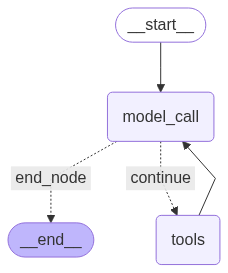

In [7]:
from IPython.display import display , Image

display(Image(agent.get_graph().draw_mermaid_png()))

In [8]:
def print_stream(stream):
    for s in stream:
        message = s['messages'][-1]
        if isinstance(message,tuple):
            print(message)
        else:
            message.pretty_print()


In [9]:
inputs = {'messages':[('user','add 3+4+90,then again add 5 with it,multiply the result with 2 and subtract by 10')]}

print_stream(agent.stream(inputs,stream_mode='values'))

================================ Human Message =================================

add 3+4+90,then again add 5 with it,multiply the result with 2 and subtract by 10


this is the last message : content='' additional_kwargs={'tool_calls': [{'id': 'call_jYWANxlabN47M0LuOUZwGDq0', 'function': {'arguments': '{"a": 3, "b": 4}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_pWUToOxXmmqki68RvvQcvue6', 'function': {'arguments': '{"a": 90, "b": 0}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_n2BEjyHTIOsj52lFVmLfA4NB', 'function': {'arguments': '{"a": 5, "b": 0}', 'name': 'add'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 96, 'total_tokens': 163, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BqEcLIP5HG9ZiOIdvxIL6uR8MArrx', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--2052ca22-e01e-4cf5-a